# **Import Library**

In [1]:
import pandas as pd
import re
import unicodedata
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Load Data**

In [2]:
# Load data
df = pd.read_csv("/kaggle/input/data-comment/train.csv")

# **EDA**

In [3]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
df.isnull().sum()


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
x = df.iloc[:, 2:].sum() # Chỉ lấy các cột label
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [7]:
rowsums = df.iloc[:, 2:].sum(axis=1) # Lấy các cột label và tính tổng theo từng cột
rowsums

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

/tmp/ipykernel_55/292011560.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])


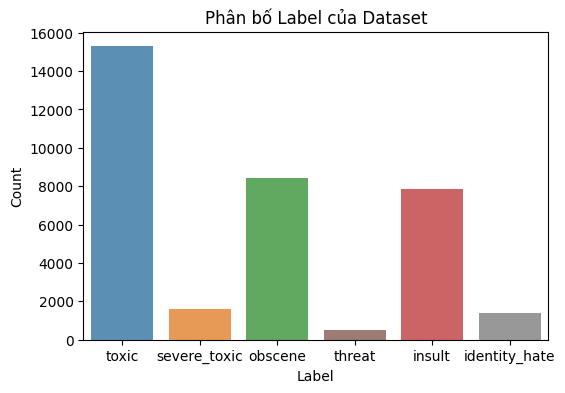

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Label của Dataset')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

/tmp/ipykernel_55/125999140.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
/tmp/ipykernel_55/125999140.py:2: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])


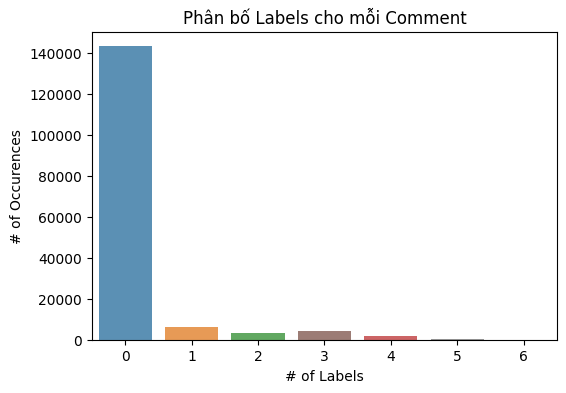

In [10]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Labels cho mỗi Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

# **Data Preprocessing**

In [ ]:
df = df.drop(columns=['id'], axis=1)

In [12]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Fill NaN

In [13]:
# Fill NaN
df['comment_text'] = df['comment_text'].fillna('').astype(str)

# Stopwords

In [ ]:

STOPWORDS = set(stopwords.words('english'))

In [15]:
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if w not in STOPWORDS]
    return " ".join(no_stopword_text)

# Clean text

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

# Stemming

In [17]:
stemmer = SnowballStemmer('english')

def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [18]:
df['comment_text'] = df['comment_text'].apply(remove_stopwords)
df['comment_text'] = df['comment_text'].apply(clean_text)
df['comment_text'] = df['comment_text'].apply(stemming)

In [19]:
df.head(15)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0,0,0,0
5,congratul well use tool well talk,0,0,0,0,0,0
6,cocksuck befor you piss around on my work,1,1,1,0,1,0
7,your vandal matt shirvington articl revert ple...,0,0,0,0,0,0
8,sorri word nonsens offens you anyway i am inte...,0,0,0,0,0,0
9,align subject contrari dulithgow,0,0,0,0,0,0


# **Split Data**

In [20]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
X = df["comment_text"]
Y = df[labels].values

# **Save pickle**

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words="english"
)

X_vec = vectorizer.fit_transform(X)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)
print('Save')

Save


# **Data Loader**

In [22]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
X_tensor = torch.tensor(X_vec.toarray(), dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [23]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_tensor, Y_tensor, test_size=0.3, random_state=42,stratify=df[labels].sum(axis=1) > 0
)


In [24]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_val shape: {Y_val.shape}")

X_train shape: torch.Size([111699, 10000])
X_val shape: torch.Size([47872, 10000])
Y_train shape: torch.Size([111699, 6])
Y_val shape: torch.Size([47872, 6])


In [25]:
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
print("DataLoaders created.")

DataLoaders created.


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Model

In [ ]:
# 5. Define Model
class ToxicMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        return self.net(x)

model = ToxicMLP(X_tensor.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
        
print("Model, criterion, and optimizer initialized.")
#Training Loop
num_epochs = 3
threshold = 0.5
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()
        correct_train += (preds == yb).sum().item()
        total_train += yb.numel()

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            total_val_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > threshold).float()
            correct_val += (preds == yb).sum().item()
            total_val += yb.numel()

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print(f"Saved best model with Val Acc: {best_val_acc:.4f}")

print("Training complete.")

Model, criterion, and optimizer initialized.
Starting training...
Epoch 1/3 | Train Loss: 0.0642 | Train Acc: 0.9787 | Val Loss: 0.0551 | Val Acc: 0.9810
Saved best model with Val Acc: 0.9810
Epoch 2/3 | Train Loss: 0.0440 | Train Acc: 0.9841 | Val Loss: 0.0558 | Val Acc: 0.9811
Saved best model with Val Acc: 0.9811
Epoch 3/3 | Train Loss: 0.0320 | Train Acc: 0.9883 | Val Loss: 0.0610 | Val Acc: 0.9800
Training complete.


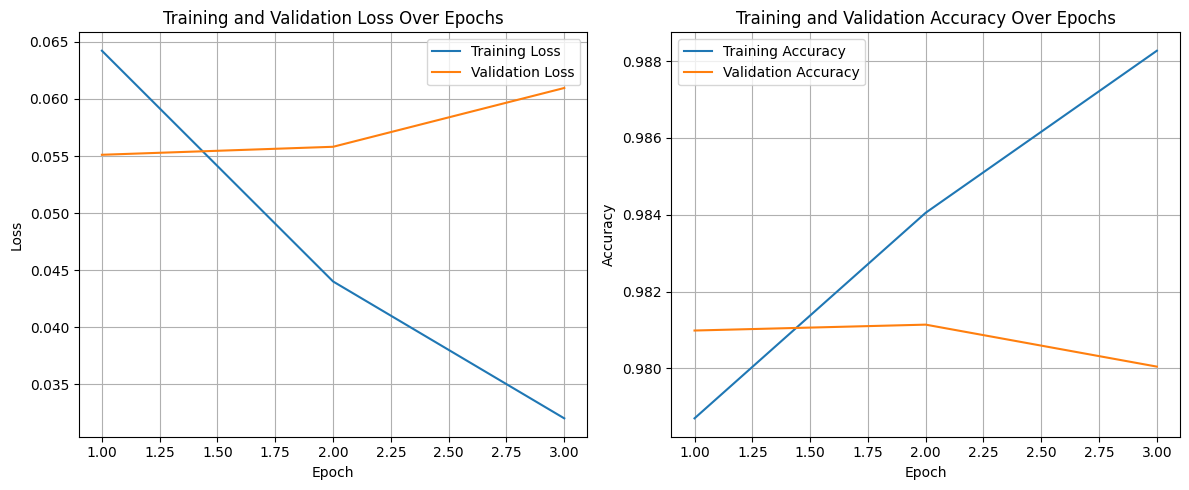

Plots generated for loss and accuracy.


In [ ]:
import matplotlib.pyplot as plt
#  Visualize Training and Validation Loss/Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 8. Evaluate Overfitting (Summary of findings will be a separate markdown block)
print("Plots generated for loss and accuracy.")


# Predict

In [29]:
import torch.nn.functional as F

def predict_toxic_2(text, threshold=0.5):
    text = clean_text(text)
    vec = vectorizer.transform([text])
    vec = torch.tensor(vec.toarray(), dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(vec)
        probs = torch.sigmoid(logits).squeeze(0).cpu().numpy()

    return {
        labels[i]: float(probs[i])
        for i in range(len(labels))
        if probs[i] > threshold
    }

In [65]:
predict_toxic_2('fucking dumb bro') 

{'toxic': 0.951194703578949,
 'obscene': 0.9367398023605347,
 'insult': 0.9186968207359314}

In [31]:
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
import numpy as np
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

y_prob = np.vstack(all_probs)
y_true = np.vstack(all_labels)

In [32]:
y_pred = (y_prob > 0.5).astype(int)

# **Results Visualization**

In [33]:
print("F1 micro:", f1_score(y_true, y_pred, average="micro"))
print("F1 macro:", f1_score(y_true, y_pred, average="macro"))

F1 micro: 0.8637310454326959
F1 macro: 0.8037475384461731


In [34]:
for i, label in enumerate(labels):
    auc_score = roc_auc_score(y_true[:, i], y_prob[:, i])
    print(f"{label:15s} ROC-AUC: {auc_score:.4f}")


toxic           ROC-AUC: 0.9865
severe_toxic    ROC-AUC: 0.9938
obscene         ROC-AUC: 0.9920
threat          ROC-AUC: 0.9893
insult          ROC-AUC: 0.9895
identity_hate   ROC-AUC: 0.9896


In [35]:
for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    print(f"{label:15s} PR-AUC: {pr_auc:.4f}")


toxic           PR-AUC: 0.9393
severe_toxic    PR-AUC: 0.7115
obscene         PR-AUC: 0.9443
threat          PR-AUC: 0.7710
insult          PR-AUC: 0.8963
identity_hate   PR-AUC: 0.8053


In [36]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, accuracy_score
import numpy as np



precision_per_label = []
recall_per_label = []
f1_per_label = []
accuracy_per_label = []


for i, label_name in enumerate(labels):
    # F1, Precision, Recall
    precision = precision_score(y_true[:, i], y_pred[:, i], zero_division=0)
    recall = recall_score(y_true[:, i], y_pred[:, i], zero_division=0)
    f1 = f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
    accuracy = accuracy_score(y_true[:, i], y_pred[:, i])

    precision_per_label.append(precision)
    recall_per_label.append(recall)
    f1_per_label.append(f1)
    accuracy_per_label.append(accuracy)

metrics_df_full = pd.DataFrame({
    "Label": labels,
    "Precision": precision_per_label,
    "Recall": recall_per_label,
    "F1-Score": f1_per_label,
    "Accuracy": accuracy_per_label
})

display(metrics_df_full.set_index("Label"))

,Precision,Recall,F1-Score,Accuracy
Label,,,,
toxic,0.907173,0.857526,0.881651,0.977935
severe_toxic,0.692258,0.672727,0.682353,0.993739
obscene,0.912225,0.889336,0.900635,0.989610
threat,0.842975,0.640167,0.727705,0.998565
insult,0.852790,0.842072,0.847397,0.985029
identity_hate,0.862158,0.716726,0.782744,0.996497


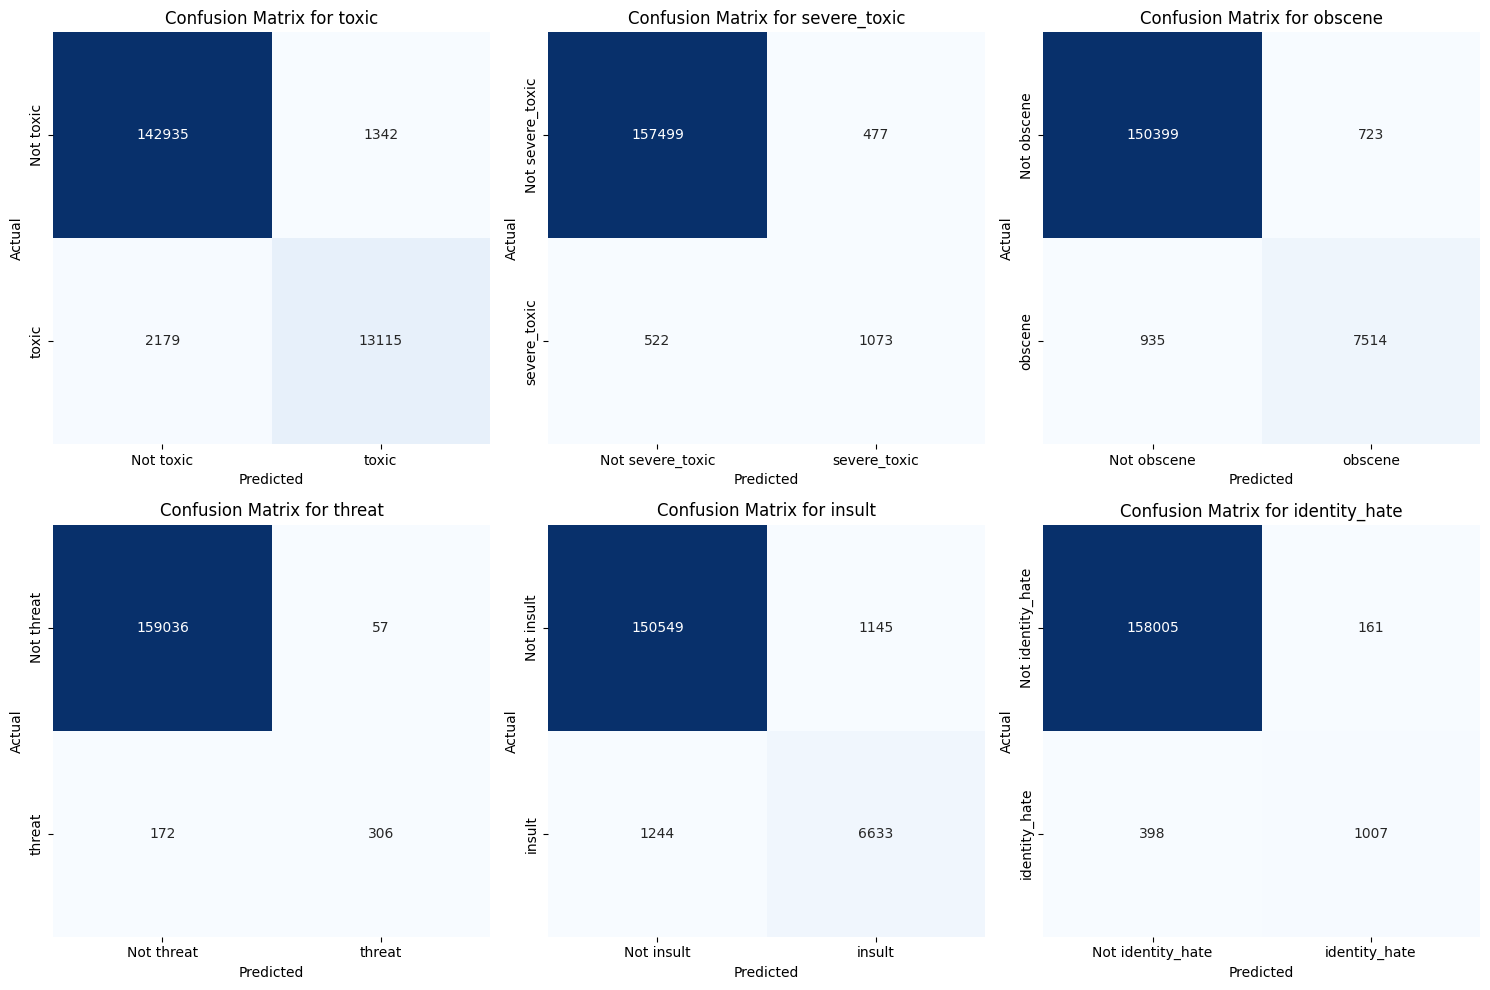

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

for i, label in enumerate(labels):
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])

    plt.subplot(2, 3, i + 1) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not ' + label, label],
                yticklabels=['Not ' + label, label])
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

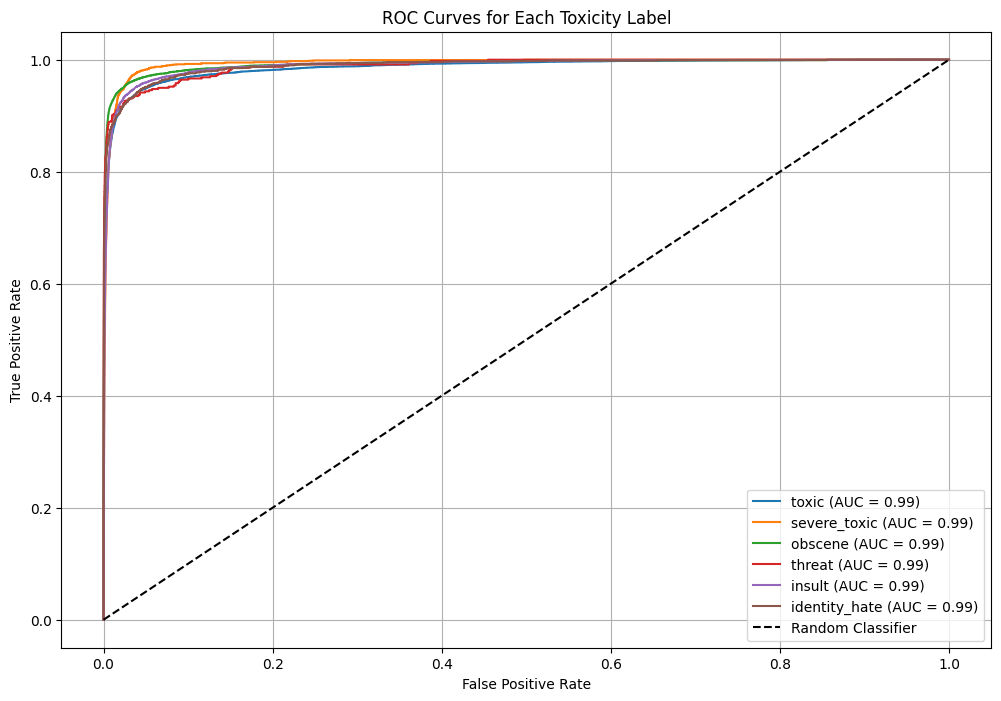

In [38]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Toxicity Label')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

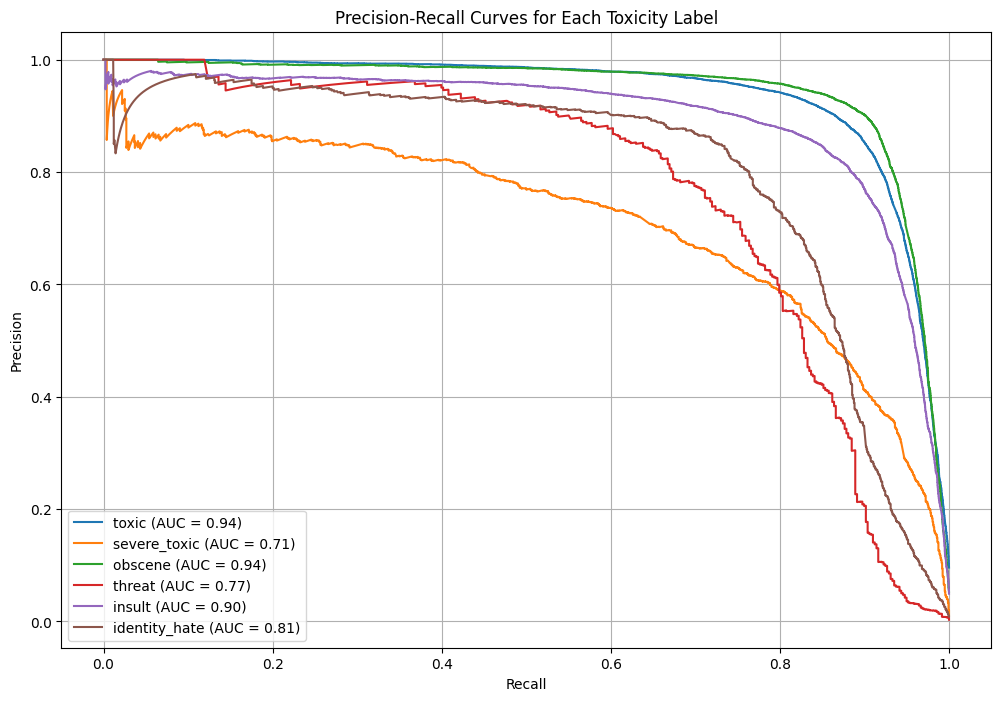

In [39]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i, label in enumerate(labels):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Toxicity Label')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

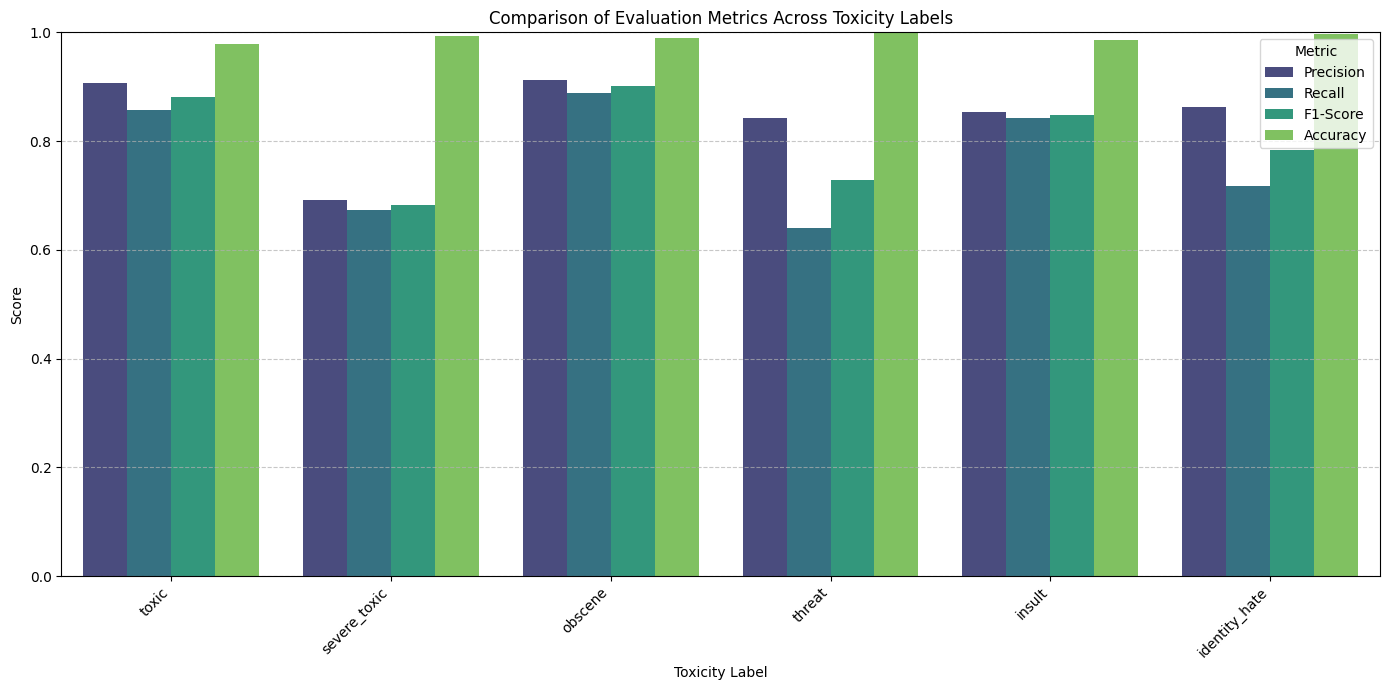

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


metrics_melted = metrics_df_full.melt(id_vars=['Label'], var_name='Metric', value_name='Score')


plt.figure(figsize=(14, 7))
sns.barplot(x='Label', y='Score', hue='Metric', data=metrics_melted, palette='viridis')
plt.title('Comparison of Evaluation Metrics Across Toxicity Labels')
plt.xlabel('Toxicity Label')
plt.ylabel('Score')
plt.ylim(0, 1) # Metrics are typically between 0 and 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()